In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import adjustText as at
from adjustText import adjust_text

players = pd.read_csv("players.csv")
teams = pd.read_csv("teams.csv")

In [ ]:
players.info()

In [ ]:
teams.info()

## Distribution of Player Experience

We start by understanding how long players have been active professionally.

**Steps:**
- Parse `proplayer_since_year` and `proplayer_since_month` into a datetime.
- Calculate `experience_months` from debut to today.
- Plot a histogram to show experience distribution.

In [ ]:
# Map month names to numbers
month_map = {month: idx for idx, month in enumerate([
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"], start=1)}

# Convert debut to datetime
# Note that because of the way our dataset was created, we assume that proplayer_since_day is always 1 (first day of the month) for uniformity
players["debut_date"] = pd.to_datetime(
    players["proplayer_since_year"].astype(str) + "-" +
    players["proplayer_since_month"].map(month_map).astype(str) + "-01"
)

# Compute experience in months
today = pd.Timestamp.today()
players["experience_months"] = (today.year - players.debut_date.dt.year) * 12 + \
                                  (today.month - players.debut_date.dt.month)

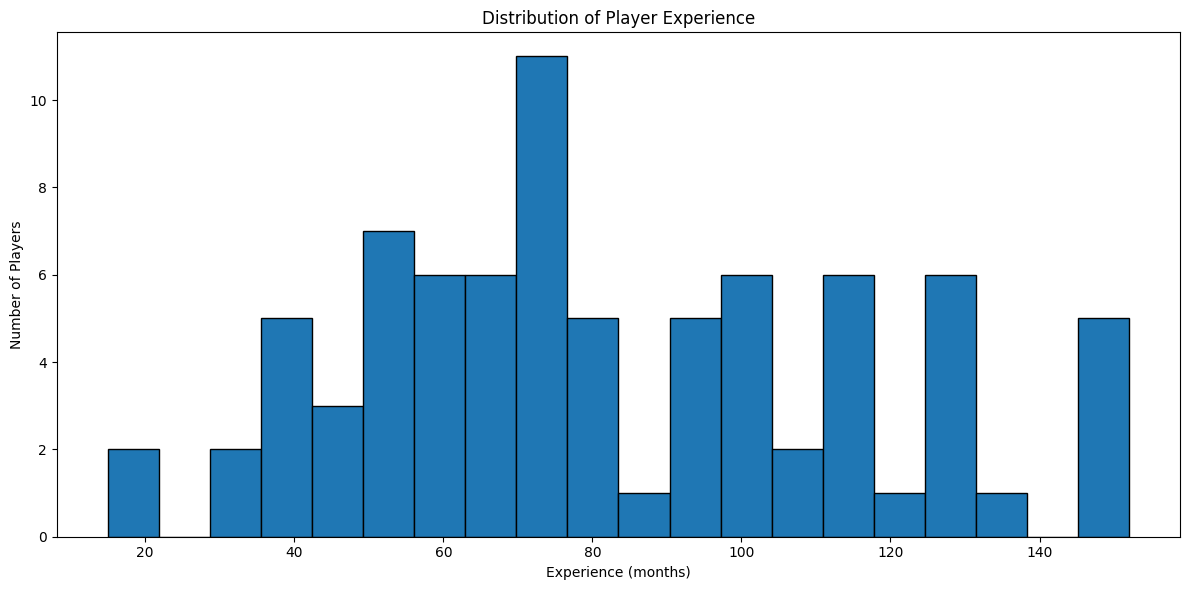

In [3]:
# Histogram
plt.figure(figsize=(12, 6))
plt.hist(players["experience_months"], bins=20, edgecolor='black')
plt.xlabel("Experience (months)")
plt.ylabel("Number of Players")
plt.title("Distribution of Player Experience")
plt.tight_layout()
plt.show()

## Top 5 Most Experienced Players from Top 3 Teams

We could then identify the "elite" players from the best-performing teams.

**Steps:**
- Find the top 3 teams by `tournament_place`.
- Filter players from these teams.
- Rank by experience in months and take the top 5.

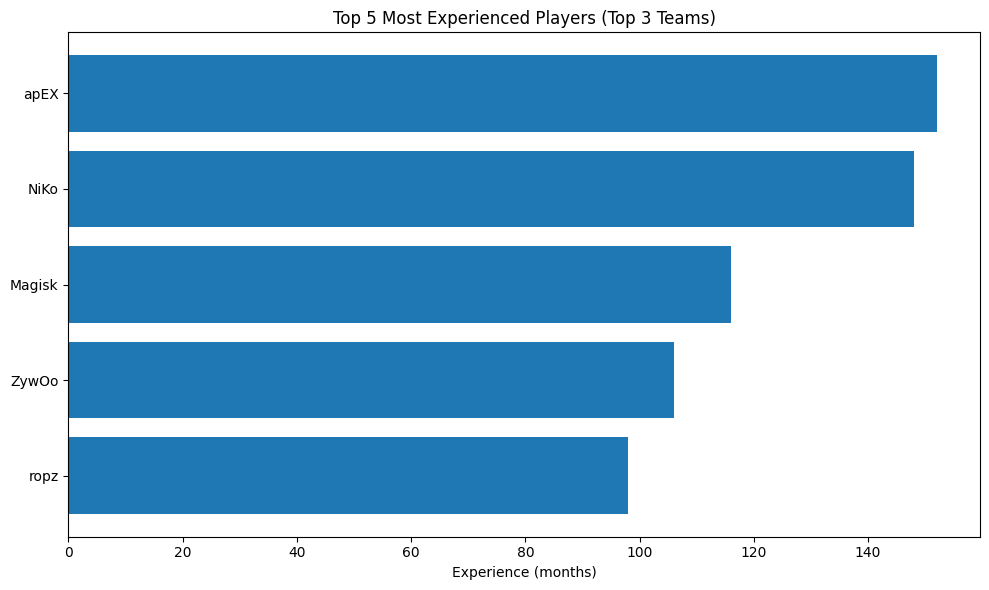

In [ ]:
top_teams = teams.sort_values("tournament_place").head(3)["team_name"].tolist()
top_team_players = players[players["team"].isin(top_teams)]
top_experienced_players = top_team_players.sort_values("experience_months", ascending=False).head(5)

# Bar plot
plt.figure(figsize=(10, 6))
plt.barh(top_experienced_players["name"], top_experienced_players["experience_months"])
plt.xlabel("Experience (months)")
plt.title("Top 5 Most Experienced Players (Top 3 Teams)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Player Experience vs Tournament Placement

Next, we assess whether individual player experience correlates with better team placements.

**Steps:**
- Merge player data with tournament results.
- Plot each player's experience against their team's tournament placement.
- Use `adjustText` to resolve overlapping labels.

54 [-0.41556202 -0.99183753]
59 [ 0.3563826  -0.81450922]


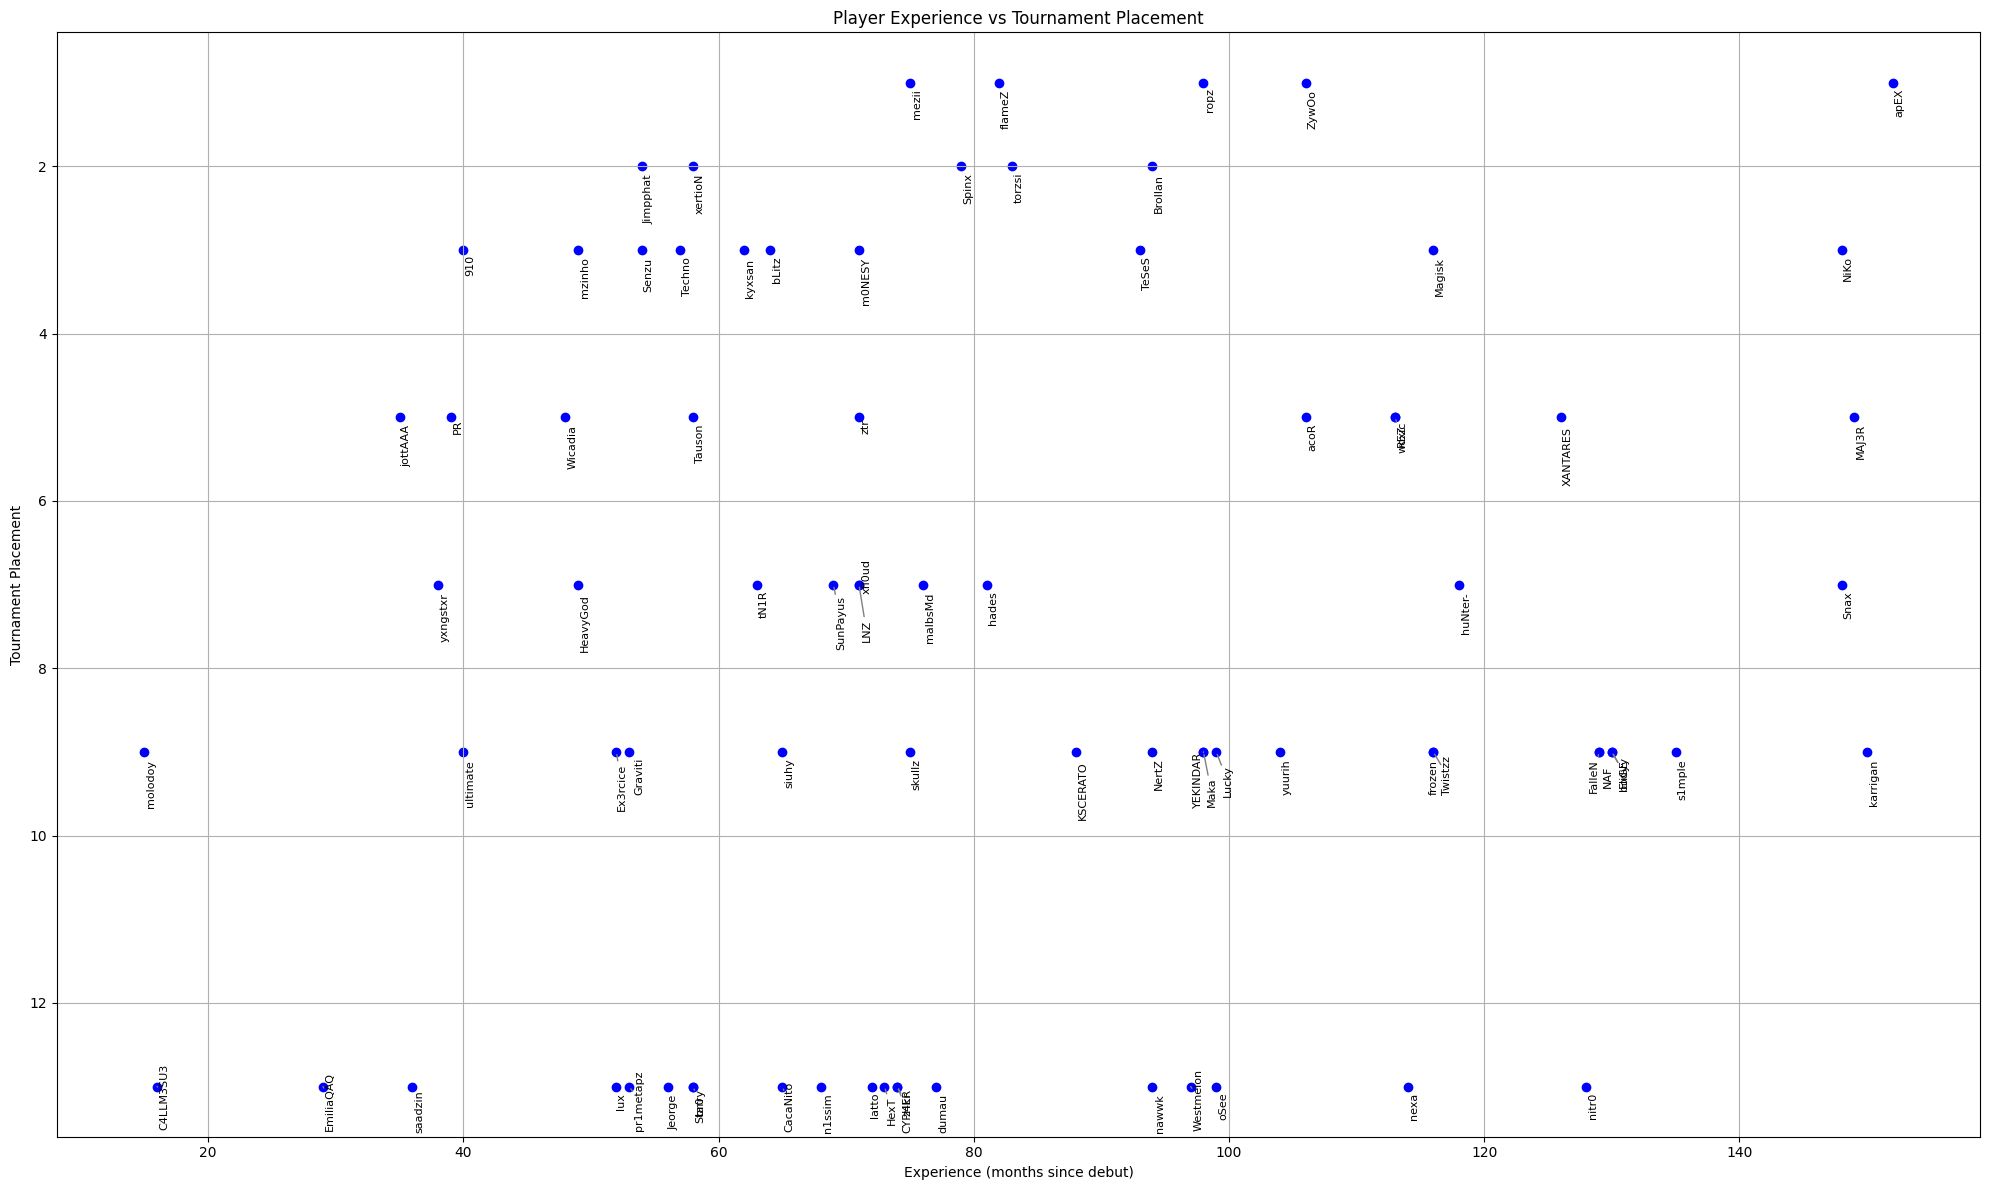

In [ ]:
df = players.merge(teams, left_on="team", right_on="team_name")

# Scatterplot
plt.figure(figsize=(20, 12))
plt.scatter(df["experience_months"], df["tournament_place"], color="blue")
texts = [
    plt.text(row["experience_months"], row["tournament_place"], row["name"], fontsize=8, rotation=90)
    for _, row in df.iterrows()
]
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))
plt.gca().invert_yaxis()
plt.xlabel("Experience (months since debut)")
plt.ylabel("Tournament Placement")
plt.title("Player Experience vs Tournament Placement")
plt.grid(True)
plt.tight_layout()
plt.show()

## Team Roster Tenure vs Tournament Placement

We could also analyze how long a team’s current roster has been together and whether that impacts performance.

**Steps:**
- Convert `on_team_since` for each player.
- Get the latest join date (youngest tenure) for each team.
- Calculate months since that join date (i.e. roster tenure).
- Merge with tournament results and plot.

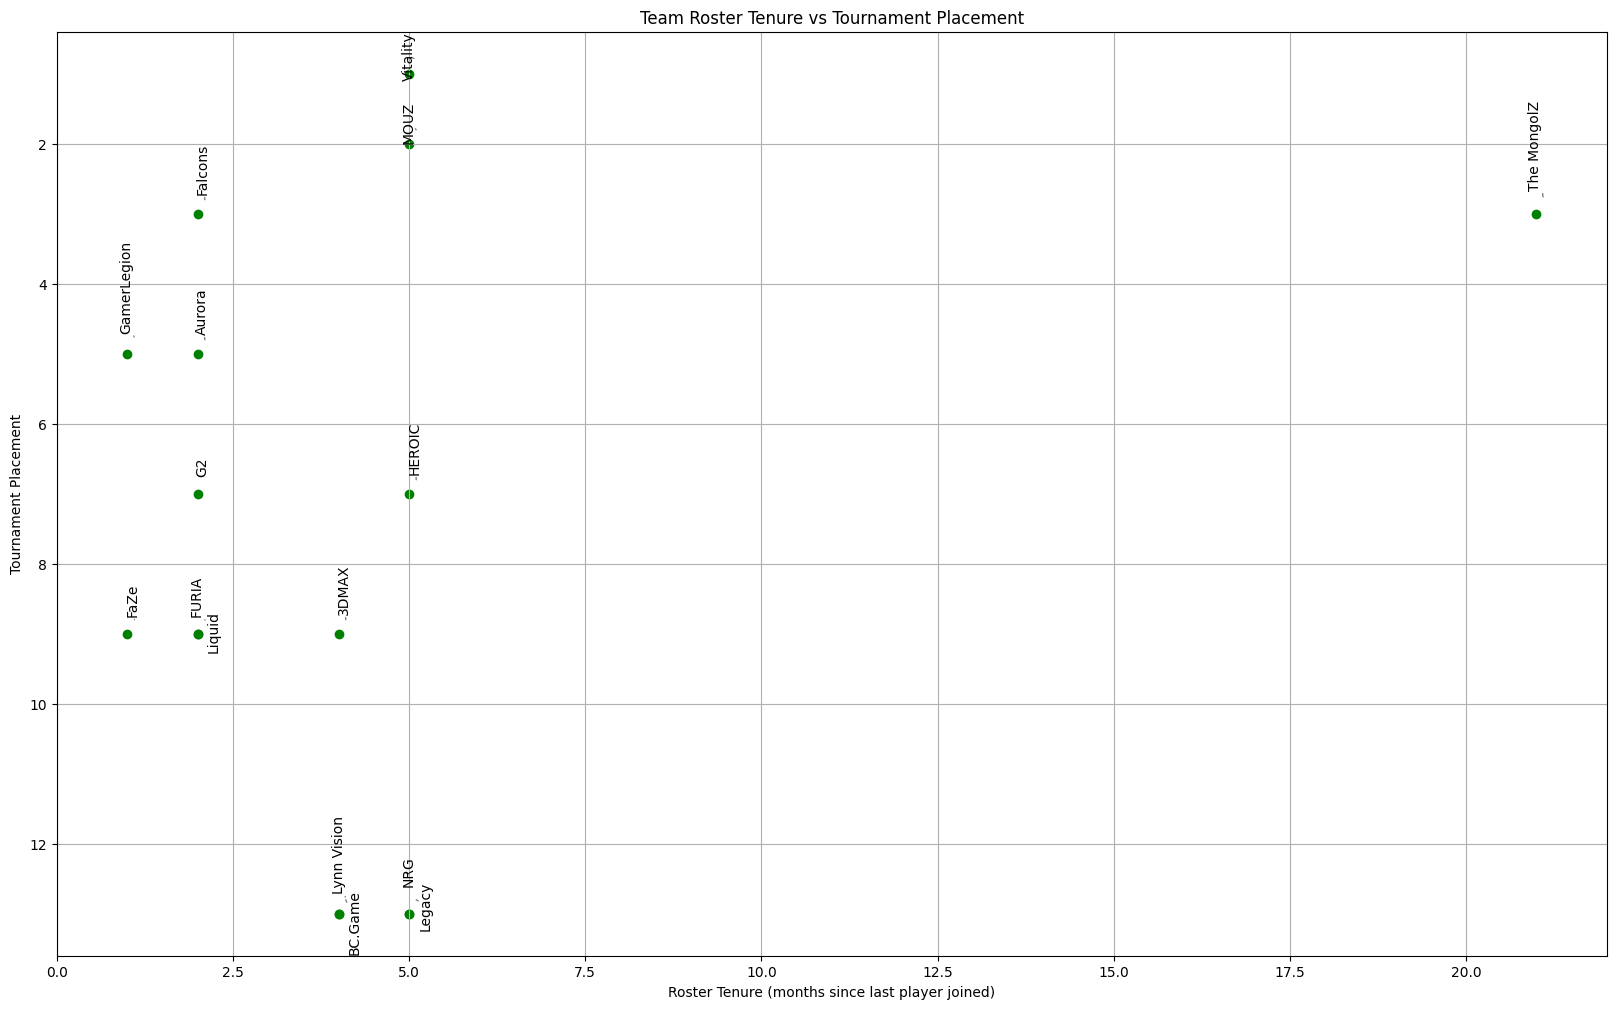

In [ ]:
# Convert team join date to datetime
players["on_team_since"] = pd.to_datetime(
    players["on_team_since_year"].astype(str) + "-" +
    players["on_team_since_month"].map(month_map).astype(str) + "-01"
)

latest_join_df = players.groupby("team")["on_team_since"].max().reset_index()

# Compute roster tenure (months since newest member joined)
today = pd.Timestamp.today()
latest_join_df["roster_tenure_months"] = (today.year - latest_join_df["on_team_since"].dt.year) * 12 + \
                                          (today.month - latest_join_df["on_team_since"].dt.month)

team_df = latest_join_df.merge(teams, left_on="team", right_on="team_name")

# Scatterplot
plt.figure(figsize=(20, 12))
plt.scatter(team_df["roster_tenure_months"], team_df["tournament_place"], color="green")

# Note that I had to use adjust_text to avoid overlapping text labels and make the plot more readable
texts = [
    plt.text(
                row["roster_tenure_months"] + 0.1, 
                row["tournament_place"] - 0.2, 
                row["team_name"], 
                fontsize=10, 
                rotation=90, 
                verticalalignment='top',
                horizontalalignment='center'
            )
    for _, row in team_df.iterrows()
]
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.gca().invert_yaxis()
plt.xlabel("Roster Tenure (months since last player joined)")
plt.ylabel("Tournament Placement")
plt.title("Team Roster Tenure vs Tournament Placement")
plt.grid(True)
plt.show()